In [93]:
import numpy as np
import os
import glob
import shutil
import matplotlib.pyplot as plt
import json
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from IPython.display import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Module for computations (if needed)

In [94]:
import FEM_utilities as FEM

# Lab 05: Riks method

## Write input file

Set parameters for simulation:

- *isRiks* : whether to perform **Riks** or **Newton-Raphson** analysis
- *basename* : name used for input file and directory
- *eltype* : type of truss element (see conventions [here](http://server-ifb147.ethz.ch:2080/v6.14/books/usb/default.htm))
- *matname*: name of material
- **E**, $\nu$: elastic properties (Young modulus and Poisson ratio, as *TYPE* is by default **isotropic**)
- **EA** : cross-sectional properties of truss [N]
- *elname*: **\*Elset** assigned name

In [95]:
def write_inp_file(L, z0, nn, eltype, elname, isRiks, matname, A, E, ν, increment, t_data, F):
    
    n_coords = np.zeros((nn,2))
    
    for ni in range(1,nn):
        n_coords[ni,:] = ni/(nn-1)*np.array([L, z0])
    
    if isRiks:
        basename = 't_ne'+str(nn-1).zfill(2)+'_aR_s'+str(int(t_data[3]*100)).zfill(3)
    else:
        basename = 't_ne'+str(nn-1).zfill(2)+'_aN_s'+str(int(t_data[3]*100)).zfill(3)

    
    filename = basename+'.inp'
    
    outfile = open(filename, "wt")
    
    outfile.write("** Lab 05 input file test\n")
    
    # NODES section
    
    outfile.write("**\n")
    outfile.write("** Nodes\n")
    outfile.write("**\n")
    outfile.write("*NODE\n")
    
    for i in range(nn):
        nodestring = "{0:4d},{1:8},{2:8}\n".format(i+1,n_coords[i,0],n_coords[i,1])
        outfile.write(nodestring)
    
    # ELEMENTS section
        
    outfile.write("**\n")
    outfile.write("** Elements\n")
    outfile.write("**\n")
    outfile.write("*ELEMENT, TYPE={0}, ELSET={1}\n".format(eltype,elname))
    for i in range(1,nn):
        outfile.write("{0:4d},{1:4d},{2:4d}\n".format(i,i,i+1))
    
    # SOLID section
    
    outfile.write("**\n")
    outfile.write("** Solid section\n")
    outfile.write("**\n")
    outfile.write("*SOLID SECTION, MATERIAL={0}, ELSET={1}\n".format(matname,elname))
    outfile.write(str(A)+",\n")
    # MATERIAL section
    
    outfile.write("**\n")
    outfile.write("** Materials\n")
    outfile.write("**\n")
    outfile.write("*MATERIAL, name = {0}\n".format(matname))
    outfile.write("*ELASTIC\n")
    outfile.write("{0},{1:6}\n".format(E,ν))
    
    
    # BOUNDARY CONDITIONS
    
    outfile.write("**\n")
    outfile.write("** Boundary conditions\n")
    outfile.write("**\n")
    outfile.write("*BOUNDARY\n")
    outfile.write("1,\t1,\t3\n")
    outfile.write("{0},\t1\n".format(nn))
    outfile.write("{0},\t3\n".format(nn))
    
    # calculation steps
    
    outfile.write("**\n")
    outfile.write("** Step\n")
    outfile.write("**\n")
    
    outfile.write("*STEP, NLGEOM, INC={0}\n".format(increment))
    if isRiks:
        outfile.write("*STATIC, RIKS\n")
    else:
        outfile.write("*STATIC\n")
    outfile.write("{0:8},{1:8},{2:8},{3:8}\n".format(t_data[0], t_data[1], t_data[2], t_data[3]))
    
    # LOADS
    
    outfile.write("**\n")
    outfile.write("** Loads\n")
    outfile.write("**\n")
    outfile.write("*Cload\n")
    outfile.write("{0}, {1:2d}, {2}\n".format(nn, 2, -F ))
    
    
    outfile.write("*OUTPUT,FIELD\n")
    outfile.write("*ELEMENT OUTPUT\n")
    outfile.write("S,COORD,\n")
    outfile.write("*EL PRINT\n")
    outfile.write(" S,COORD,\n")
    outfile.write("*OUTPUT,FIELD\n")
    outfile.write("*NODE OUTPUT\n")
    outfile.write("U,COORD\n")
    outfile.write("*NODE PRINT\n")
    outfile.write("U,COORD\n")
    outfile.write("*OUTPUT,HISTORY,FREQUENCY={0}\n".format(increment))
    
    outfile.write("*END STEP\n")

    outfile.close()
    
    if not os.path.exists('../Lab05_abaqus/'+basename+'/'):
        os.makedirs('../Lab05_abaqus/'+basename+'/')

    shutil.move(filename,'../Lab05_abaqus/'+basename+'/'+filename)

In [96]:
L = 2500. # lenght [mm]
z0 = 25.  # initial height [mm]

isRiks = True


eltype = 'T3D2H'
elname = 'EALL'

matname = 'material_1'

E = 72000. # modulus [MPa]
ν = 0.33   # Poisson's coefficient

EA = 5e7   # cross sectional properties [N]

A = EA/E   # area of cross section [mm^2]

# step parameters

increment = 1000 # max number of calculation steps

# dt0, t_tot, dt_min, dt_max
t_data1 = [0.05, 1.0, 1e-4, 0.05]
t_data2 = [0.25, 1.0, 0.25, 0.25]

ts = [t_data1, t_data2]

# load

F = 15   # load [N]

num_nodes = [2, 3, 6]

for k in num_nodes:
    # shall we perform Riks analysis
    for isRiks in [True, False]:
        # time steps
        for td in ts:
            write_inp_file(L, z0, k, eltype, elname, isRiks, matname, A, E, ν, increment, td, F)

In [101]:
current_dir = os.getcwd()
os.chdir("../Lab05_abaqus/")

In [104]:
# %%bash
#./lab05.py

In [106]:
os.chdir(current_dir)

## Analytical solutions:

$F-w$ analytical relation:

$F = -\frac{EA}{L^3} \cdot ( z^2 \cdot w + \frac{3}{2}z \cdot w^2 + \frac{1}{2}w^3 )$



In [107]:
w_z_max = 2.5

w_z = np.linspace(0,w_z_max,500)
y = w_z - 1.5*w_z**2 + 0.5 * w_z**3

# Simulations' data

In [108]:
def readDataL05(filename, isRiks):
    
    file=open(filename,'r') 
    row = file.readlines()
    step = []
    U2 = []
    S11 = []
    
    state = 0

    for line in row:
        strlist = line.split()
        if 'INCREMENT' in strlist and 'SUMMARY' in strlist:
            state = 1
        elif 'U2' in strlist:
            state = 2
        elif 'S11' in strlist:
            state = 3
        elif 'TOTAL' in strlist and state == 1 and not isRiks:
            #print(strlist)
            step.append(float(strlist[-1]))
            state = 0
        elif 'FACTOR' in strlist and state == 1 and isRiks:
            step.append(float(strlist[4]))
            state = 0
        elif 'MINIMUM' in strlist and state == 2:
            U2.append(float(strlist[2]))
            state = 0
        elif 'MAXIMUM' == strlist and state == 3:
            S11.append(float(strlist[2]))
            state = 0
                
    return np.array(step), np.array(U2), np.array(S11)


In [109]:
dirs = glob.glob("../Lab05_abaqus/t_*")

sim_data = {}

for di in dirs:
    test = di.split('/')[-1]
    
    if '_aR_' in test:
        a, b, c = readDataL05(di+"/"+test+".dat", True)
    else:
        a, b, c = readDataL05(di+"/"+test+".dat", False)
        
    xy = np.zeros((len(a),2))
    
    xy[:,0] = -b/z0
    xy[:,1] = F*a*L**3/(EA*z0**3)

    sim_data[test] = xy

In [110]:
#sim_data

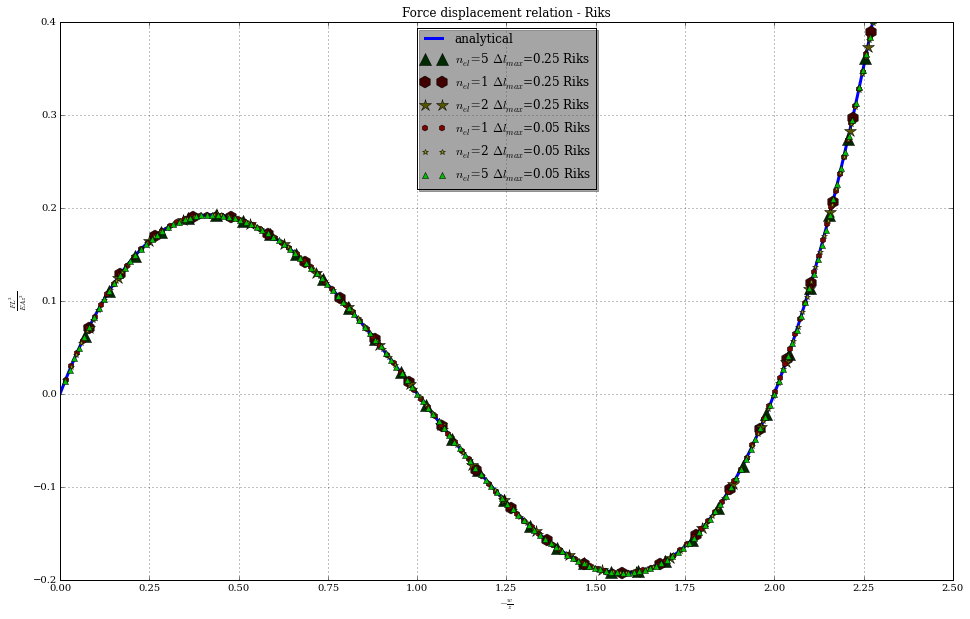

In [119]:
w_z_max = 2.5

plt.figure(figsize=(16,10), dpi=300)

plt.plot(w_z,y, '-', lw=3, label='analytical')

for i, test in enumerate(sim_data):
    n_el = int(test[4:6])
    if '_aR_' in test:
        atype = 'Riks'
        if n_el == 1:
            sym = 'h'
            c = ((i+1)/len(sim_data),0.0,0.0)
        elif n_el == 2:
            sym = '*'
            c = ((i+1)/len(sim_data),(i+1)/len(sim_data),0.0)
        else:
            sym = '^'
            c = (0.0,(i+1)/len(sim_data),0.0)

        if float(test[-3:])/100 == 0.25:
            msize = 12
        else:
            msize = 6
            
            
        lb = r"$n_{el}=$"+str(n_el)+" $\Delta l_{max}$="+str(float(test[-3:])/100)+" "+atype
        plot(sim_data[test][:,0],sim_data[test][:,1],sym, ms=msize, color=c, label=lb )

    


plt.xlim([0,w_z_max])
plt.ylim([-0.2,.4])
plt.xticks(np.arange(0.0,w_z_max+.1,0.25))
plt.yticks(np.arange(-0.2,0.4+.1,.1))
plt.title('Force displacement relation - Riks')
plt.xlabel(r'$-\frac{w}{z}$')
plt.ylabel(r'$\frac{FL^3}{EAz^3}$')
plt.legend(loc='upper center', shadow=True)
plt.grid()

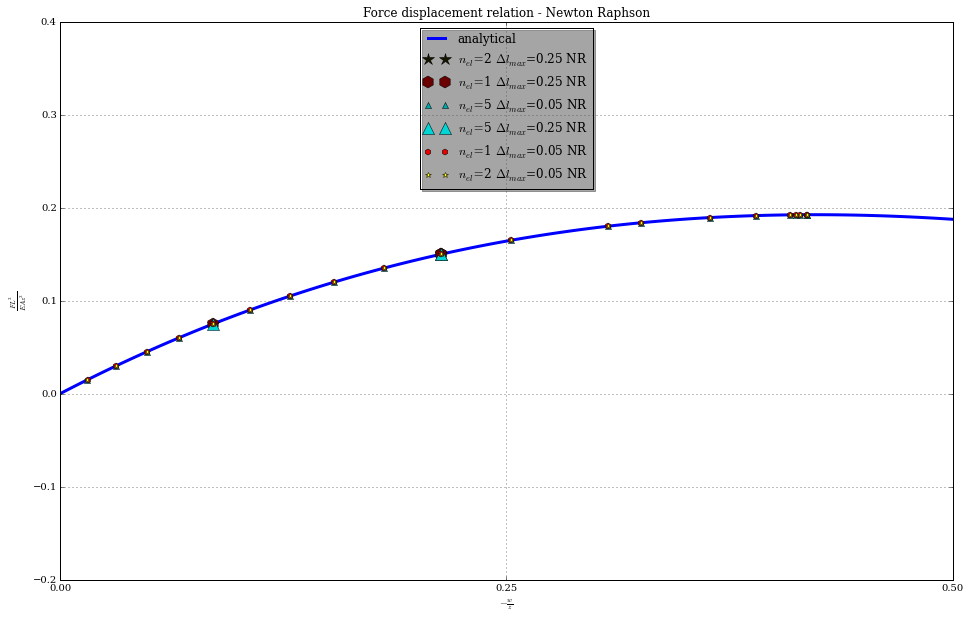

In [116]:
w_z_max =0.5

plt.figure(figsize=(16,10), dpi=300)

plt.plot(w_z,y, '-', lw=3, label='analytical')

for i, test in enumerate(sim_data):
    n_el = int(test[4:6])
    if '_aN_' in test:
        atype = 'NR'
        if n_el == 1:
            sym = 'h'
            c = ((i+1)/len(sim_data),0.0,0.0)
        elif n_el == 2:
            sym = '*'
            c = ((i+1)/len(sim_data),(i+1)/len(sim_data),0.0)
        else:
            sym = '^'
            c = (0.0,(i+1)/len(sim_data),(i+1)/len(sim_data))
        
        if float(test[-3:])/100 == 0.25:
            msize = 12
        else:
            msize = 6
            
        lb = r"$n_{el}=$"+str(n_el)+" $\Delta l_{max}$="+str(float(test[-3:])/100)+" "+atype
        plot(sim_data[test][:,0],sim_data[test][:,1],sym, ms=msize, color=c, label=lb )

    


plt.xlim([0,w_z_max])
plt.ylim([-0.2,.4])
plt.xticks(np.arange(0.0,w_z_max+.1,0.25))
plt.yticks(np.arange(-0.2,0.4+.1,.1))
plt.title('Force displacement relation - Newton Raphson')
plt.xlabel(r'$-\frac{w}{z}$')
plt.ylabel(r'$\frac{FL^3}{EAz^3}$')
plt.legend(loc='upper center', shadow=True)
plt.grid()